In [2]:
from keras.datasets import boston_housing

#loading the data
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

#preparing the data since datas are in different range we substract datas in each column 
#by the mean value and divide by standard deviation now the values in all the columns are
#centred around zero and has unit standard deviation i.e, it has been normalised
mean = train_data.mean(axis=0)                                      #axis = 0 accesses columns
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

#for test data also we use mean and std of train data, we shouldnot use properties of 
#test data in our workflow
test_data -= mean
test_data /= std

#building the neural network/ defining the network layers
#we use 3 Dense type layer, first 2 with o/p size(no of neurons) 64 having relu fn and the last one 
#with o/p size 1, a linear o/p layer, typical set up for linear scalar regression
from keras import models
from keras import layers

#since we need to instantiate the same model multiple times for validation by k-fold means
# we use a function to construct it.
#Learning process is configured with rmsprop optimiser, mean squared error(mse) loss fn and
#mean absolute error(mae) metrics
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(65, activation='relu',
              input_shape=(train_data.shape[1],)))                  #input shape = 13(no of elements in each sample=no of neurons), this code accesses the first element in the shape tuple of i/p data
    model.add(layers.Dense(65, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae']) 
    return model

#preparing data for validation
#since the size of data set is not big we use k-fold validatiion with k=4
import numpy as np

k=4
num_val_samples = len(train_data)//k # '//' python operator floor division result in whole number adjusted to left
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    
    val_data = train_data[i*num_val_samples : (i+1)*num_val_samples] #preparing validation data
    val_targets = train_targets[i*num_val_samples : (i+1)*num_val_samples]
    
    partial_train_data = np.concatenate(                             #prepare train data by concatenating 
                         [train_data[ : i*num_val_samples],          #remaining datas, axis = 0 => row wise 
                          train_data[(i+1)*num_val_samples : ]],     #so that no of elements in ach row remain 13 and only number of samples vary
                         axis = 0)

    partial_train_targets = np.concatenate(
                            [train_targets[ : i * num_val_samples],
                             train_targets[(i + 1) * num_val_samples : ]],
                            axis=0)
    
    model = build_model()                                           #builds the keras model which we configured before
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)           #verbosity = 0 menas training progress in silent mode, no information will be displayed while training is ongoing
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)    
    all_scores.append(val_mae)
#each fold is run 100 times and the average val_mae of each fold is stored in all_scores variable

Using TensorFlow backend.


('processing fold #', 0)

('processing fold #', 1)
('processing fold #', 2)
('processing fold #', 3)


In [50]:
np.mean(all_scores)                                                  #printing the mean absolute error of validation process

2.4805113673210144

In [8]:
#as we can see the mae for val data is around 2500$ which is high
#so we try to reduce it by training the network a bit longer about 500 epochs
num_epochs = 500
all_mae_histories = []                                               #keeping a record of all val mae

for i in range(k):
    print('processing fold #', i)
    
    val_data = train_data[i*num_val_samples : (i+1)*num_val_samples] #preparing validation data
    val_targets = train_targets[i*num_val_samples : (i+1)*num_val_samples]
    
    partial_train_data = np.concatenate(                             #prepare train data by concatenating 
                         [train_data[ : i*num_val_samples],          #remaining datas, axis = 0 => row wise 
                          train_data[(i+1)*num_val_samples : ]],     #so that no of elements in ach row remain 13 and only number of samples vary
                         axis = 0)

    partial_train_targets = np.concatenate(
                            [train_targets[ : i * num_val_samples],
                             train_targets[(i + 1) * num_val_samples : ]],
                            axis=0)
    
    model = build_model()                                            #builds the keras model which we configured before
    history = model.fit(partial_train_data, partial_train_targets,
              validation_data=(val_data, val_targets),
              epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)                          
    
#building history of successive mean k-fold validation scores : here we have 4 sets of 500mae values corresponding to 500 iterations in 4 folds
#after they are appended as 4 seperate elemnts/vector of 500mae values, we calculate mean of each those elements and result is
#a single vector with 500mae values comprising average of all 4 folds
average_mae_history = [np.mean([x[i] for x in all_mae_histories])
                       for i in range(num_epochs)]


('processing fold #', 0)
('processing fold #', 1)
('processing fold #', 2)
('processing fold #', 3)


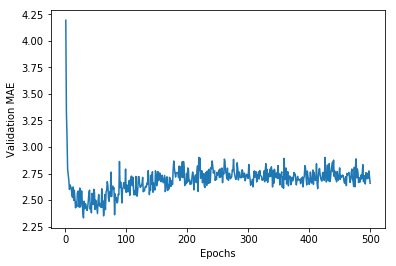

In [22]:
#plotting the average mae (500 values) of 4 folds 
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

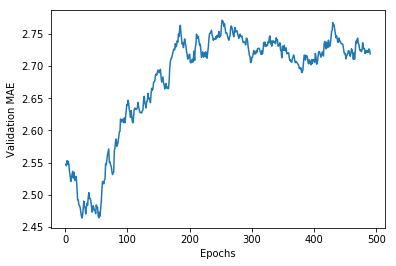

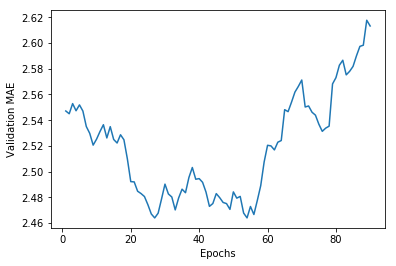

In [40]:
#from the above figure we can see that the curve is not smooth and we cannot get an accurate idea
#about the mae so we smooth the curve by removing first 10 values, since thay are on a different scale compared to the other
#also replacing each point with the exponential moving average of its previous point for this we define a function first
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:                                     #this is a bolean check here if smoothed_points=0 then else statement is executed, otherwise if smoothed_points!=0 then if statement is executed
            previous = smoothed_points[-1]                      #accesses the last element in smoothed_points tensor
            smoothed_points.append(previous*factor + point*(1-factor))
        else:
            smoothed_points.append(point)                       #else will be executed only once after that first point goes into smoothed_points, it is then !=0 
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])    #omitting the first 10 values since they are on a different scale wrt other points

#plotting the smoothed average mae values of 4 fold
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

smooth_mae_history = smooth_curve(average_mae_history[10:100])    #taking a closer look to first 100 points

#plotting the smoothed average mae values of 4 fold
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [6]:
#from the above plot we can see that the average mae is not improving after about 60 epochs
#past that points  it strt to overfit, so training a final model with 60 epochs
model = build_model()
model.fit(train_data, train_targets,
          epochs=100, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

102/102 [==============================] - 0s 455us/step


2.6800804138183594